# Analyze the statistics of the teacher outputs
---
The purpose of this notebook is to compare the teacher regression outputs w.r.t. different GIN initializations.

## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [9]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from functools import partial
from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

Import the model and some necessary utility functions.

In [3]:
import sys
import torch

from torch import nn
from torch_geometric.data import DataLoader

sys.path.append('../src')

import models.GIN.regression as module

from utils.convert import fromNetworkx2Torch
from utils.io import readPickle, writePickle

## Data
---
Load the dataset and perform the necessary transformations.

In [4]:
!ls "../data/synthetic/erdos_renyi"

N100_n100_p0.1_1624367054 N200_n100_p0.1_1624514787
N100_n30_p0.1_1624230420  N300_n100_p0.1_1624629108


In [5]:
dataset_filename = '../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/raw_networkx.pkl'
initial_relabeling = 'ones'

networkx_dataset = readPickle(dataset_filename)
torch_dataset = fromNetworkx2Torch(networkx_dataset, initial_relabeling=initial_relabeling)
torch_dataset_loader = DataLoader(torch_dataset, batch_size=1)

## Teacher outputs
---
Init the teacher networks, and produce and store the outputs.

In [13]:
# Initialize some parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

value_range = np.arange(0.1, 5.1, 0.1)

model_kwargs = {
    'hidden_dim': 32,
    'blocks': 3,
    'residual': False,
    'jk': True,
}

In [19]:
num_iterations = 100

outputs = defaultdict(list)
for v in tqdm(value_range):
    for _ in range(num_iterations):
        # Init the model
        model = module.Net(**model_kwargs).to(device)
        model.apply(partial(module.initWeights, lower_bound=-v, upper_bound=v))
        # Forward the data and generate the teacher outputs
        teacher_outputs = module.test(model, torch_dataset_loader, device)
        outputs[v].append(teacher_outputs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
# Compute averages and std deviations (per teacher output approach)
outputs_stats = defaultdict(lambda: defaultdict(list))
for v, teacher_outputs in outputs.items():
    for i, teacher_output in enumerate(teacher_outputs):
        outputs_stats[v]['mean'].append(np.mean(teacher_output))
        outputs_stats[v]['std_dev'].append(np.std(teacher_output))
        
# Compute averages and std deviations (per value range approach)
outputs_stats_avg = defaultdict(dict)
for v, teacher_outputs in outputs_stats.items():
    v = round(v, 1)
    outputs_stats_avg[v]['mean'] = np.mean(teacher_outputs['mean'])
    outputs_stats_avg[v]['std_dev'] = np.mean(teacher_outputs['std_dev'])

In [26]:
outputs_stats_avg

defaultdict(dict,
            {0.1: {'mean': 0.0029401798, 'std_dev': 0.0090034045},
             0.2: {'mean': -0.26000226, 'std_dev': 0.45181352},
             0.3: {'mean': -2.14094, 'std_dev': 6.4947996},
             0.4: {'mean': -28.13582, 'std_dev': 53.981255},
             0.5: {'mean': 51.57676, 'std_dev': 258.13403},
             0.6: {'mean': 244.22975, 'std_dev': 1003.8137},
             0.7: {'mean': 1377.685, 'std_dev': 2967.1226},
             0.8: {'mean': 2152.3704, 'std_dev': 7531.1226},
             0.9: {'mean': 6401.629, 'std_dev': 13736.119},
             1.0: {'mean': 6482.0723, 'std_dev': 31654.914},
             1.1: {'mean': 8220.775, 'std_dev': 61085.23},
             1.2: {'mean': 91582.66, 'std_dev': 131406.06},
             1.3: {'mean': -23227.828, 'std_dev': 188922.69},
             1.4: {'mean': -6787.8623, 'std_dev': 340333.2},
             1.5: {'mean': 123202.75, 'std_dev': 555812.2},
             1.6: {'mean': 226415.19, 'std_dev': 886158.6},
     

Plot the obtained outputs.

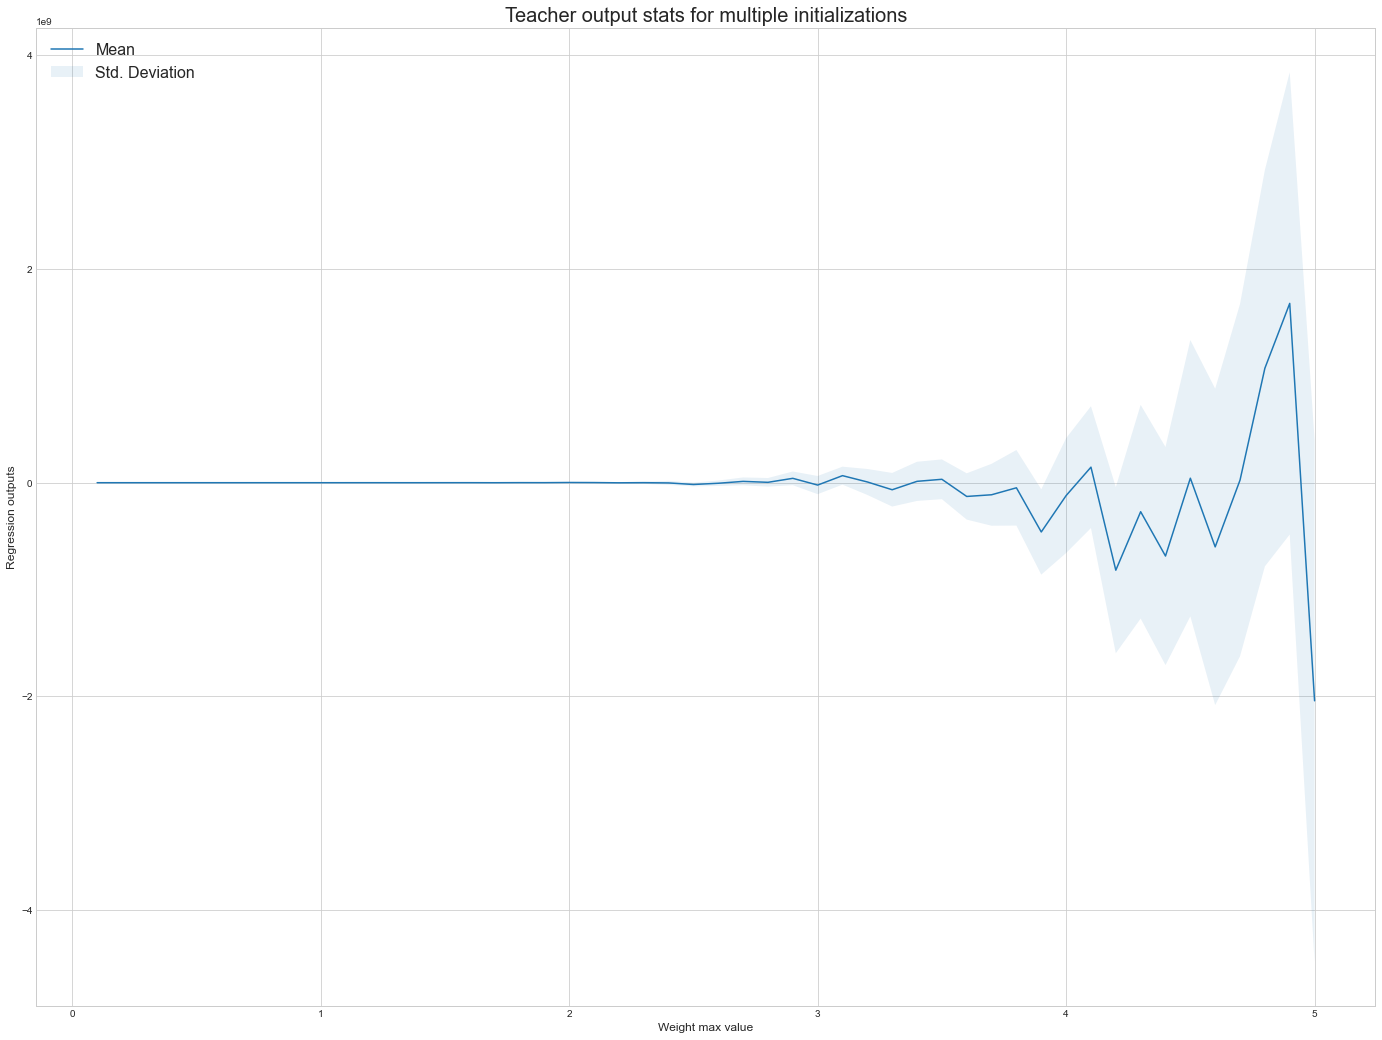

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(24, 18))

x = value_range.copy()
mean = np.array([v['mean'] for _, v in outputs_stats_avg.items()])
std_dev = np.array([v['std_dev'] for _, v in outputs_stats_avg.items()])

ax.plot(x, mean, label='Mean')
ax.fill_between(x, (mean - std_dev), (mean + std_dev), alpha=0.1, label='Std. Deviation')
ax.set_title('Teacher output stats for multiple initializations', fontsize=20)
ax.set_xlabel('Weight max value', fontsize=12)
ax.set_ylabel('Regression outputs', fontsize=12)
ax.legend(loc=2, prop={'size': 16})

plt.show()

Zoom into the first range of values to observe the variance closely.

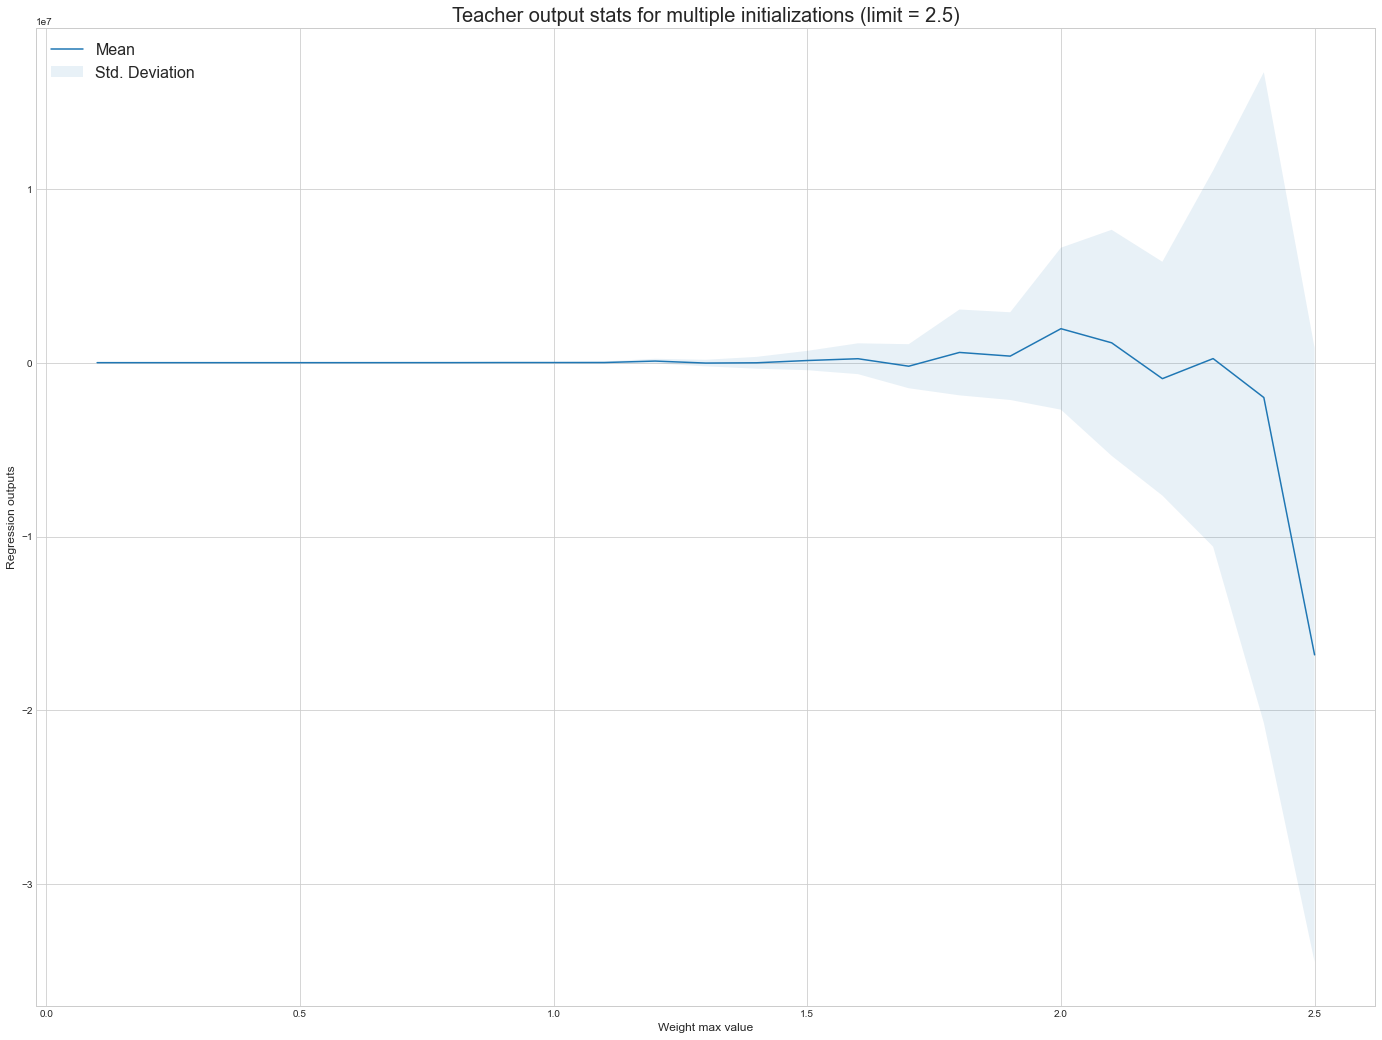

In [51]:
x_limit = 25

fig, ax = plt.subplots(1, 1, figsize=(24, 18))

x = value_range.copy()[:x_limit]
mean = np.array([v['mean'] for _, v in outputs_stats_avg.items()])[:x_limit]
std_dev = np.array([v['std_dev'] for _, v in outputs_stats_avg.items()])[:x_limit]

ax.plot(x, mean, label='Mean')
ax.fill_between(x, (mean - std_dev), (mean + std_dev), alpha=0.1, label='Std. Deviation')
ax.set_title(f'Teacher output stats for multiple initializations (limit = {0.1 * x_limit})', fontsize=20)
ax.set_xlabel('Weight max value', fontsize=12)
ax.set_ylabel('Regression outputs', fontsize=12)
ax.legend(loc=2, prop={'size': 16})

plt.show()